<a href="https://colab.research.google.com/github/lacykaltgr/continual-learning-ait/blob/main/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#from google.colab import files
#files.download()

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np

# Setup

In [3]:
!mkdir clear-10
!mkdir clear-100
!wget -O clear-10/train.zip https://clear-challenge.s3.us-east-2.amazonaws.com/clear10-train-image-only.zip
!wget -O clear-10/test.zip https://clear-challenge.s3.us-east-2.amazonaws.com/clear10-test.zip
!wget -O clear-100/train.zip https://clear-challenge.s3.us-east-2.amazonaws.com/clear100-train-image-only.zip
!wget -O clear-100/test.zip https://clear-challenge.s3.us-east-2.amazonaws.com/clear100-test.zip

--2023-04-07 15:43:28--  https://clear-challenge.s3.us-east-2.amazonaws.com/clear10-train-image-only.zip
Resolving clear-challenge.s3.us-east-2.amazonaws.com (clear-challenge.s3.us-east-2.amazonaws.com)... 52.219.84.32
Connecting to clear-challenge.s3.us-east-2.amazonaws.com (clear-challenge.s3.us-east-2.amazonaws.com)|52.219.84.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1000114669 (954M) [application/zip]
Saving to: ‘clear-10/train.zip’

clear-10/train.zip  100%[===================>] 953.78M  39.4MB/s    in 26s     

2023-04-07 15:43:54 (37.2 MB/s) - ‘clear-10/train.zip’ saved [1000114669/1000114669]

--2023-04-07 15:43:54--  https://clear-challenge.s3.us-east-2.amazonaws.com/clear10-test.zip
Resolving clear-challenge.s3.us-east-2.amazonaws.com (clear-challenge.s3.us-east-2.amazonaws.com)... 52.219.92.226
Connecting to clear-challenge.s3.us-east-2.amazonaws.com (clear-challenge.s3.us-east-2.amazonaws.com)|52.219.92.226|:443... connected.
HTTP request 

In [ ]:
!unzip clear-10/train.zip -d clear-10/
!unzip clear-10/test.zip -d clear-10/
!unzip clear-100/train.zip -d clear-100/
!unzip clear-100/test.zip -d clear-100/

In [ ]:
import glob

train_clear_10_image_paths = glob.glob("clear-10/train_image_only/labeled_images/*/*/*.jpg")
test_clear_10_image_paths = glob.glob("clear-10/test/labeled_images/*/*/*.jpg")
train_clear_100_image_paths = glob.glob("clear-100/train_image_only/labeled_images/*/*/*.jpg")
test_clear_100_image_paths = glob.glob("clear-100/test/labeled_images/*/*/*.jpg")

clear_10_features_path = "clear-10/test/class_names.txt"
clear_100_features_path = "clear-100/test/class_names.txt"

In [ ]:
def _bytes_feature(value):
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() 
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
  

def image_example(image_string, date, task):
  feature = {
      'date': _bytes_feature(date),
      'task': _bytes_feature(task),
      'image_raw': _bytes_feature(image_string),
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

def write_to_tfrecord(image_paths, tfrecord_file_name):
  with tf.io.TFRecordWriter(f"{tfrecord_file_name}.tfrecord") as writer:
    for path in image_paths:
      date = path.split("/")[-3].encode()
      task = path.split("/")[-2].encode()
      with open(path, "rb") as image:
        image_string = image.read()
        tf_example = image_example(image_string, date, task)
        writer.write(tf_example.SerializeToString())

In [ ]:
write_to_tfrecord(train_clear_10_image_paths, 'train-clear-10')
write_to_tfrecord(test_clear_10_image_paths, 'test-clear-10')
write_to_tfrecord(train_clear_100_image_paths, 'train-clear-100')
write_to_tfrecord(test_clear_100_image_paths, 'test-clear-100')

In [ ]:
#from google.colab import files
#files.upload()

# CLeaR

In [ ]:
from tensorflow.keras.preprocessing.image import smart_resize
import tensorflow_datasets as tfds

IMAGE_SIZE = [256, 256]


def feature_encode_table(filepath):
    vocab = tf.io.read_file(filepath)
    vocab = tf.strings.split(vocab, sep="\n")
    vocab_size = tf.shape(vocab)[0]

    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(vocab, tf.range(vocab_size)),
        default_value = -1
    )
    return table

def encode_task(task, feature_table):
    task_indices = feature_table.lookup(task)
    task_one_hot = tf.one_hot(task_indices, depth=int(feature_table.size()))
    return task_one_hot

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = smart_resize(image, IMAGE_SIZE)
    return image


def read_tfrecord_features(example, tfrecord_format):
    example = tf.io.parse_single_example(example, tfrecord_format)
    date = tf.strings.to_number(example['date'], out_type=tf.int32)
    image = decode_image(example['image_raw'])
    return (image, date)

def read_tfrecord_labels(example, feature_table, tfrecord_format):
    example = tf.io.parse_single_example(example, tfrecord_format)
    task = encode_task(example['task'], feature_table)
    return task


def load_dataset(record_filepath, feature_filepath):
    tfrecord_format = {
        "date": tf.io.FixedLenFeature([], tf.string),
        "task": tf.io.FixedLenFeature([], tf.string),
        "image_raw": tf.io.FixedLenFeature([], tf.string)
    }
    dataset = tf.data.TFRecordDataset(record_filepath)
    table = feature_encode_table(feature_filepath)
    X = dataset.map(lambda x: read_tfrecord_features(x, tfrecord_format))
    y = dataset.map(lambda x: read_tfrecord_labels(x, table, tfrecord_format))
    return (X, y)

In [ ]:
X_train_clear_10, y_train_clear_10 = load_dataset('train-clear-10.tfrecord', clear_10_features_path)
X_test_clear_10, y_test_clear_10 = load_dataset('train-clear-10.tfrecord', clear_10_features_path)
X_train_clear_100, y_train_clear_100 = load_dataset('train-clear-10.tfrecord', clear_10_features_path)
X_test_clear_100, y_test_clear_100 = load_dataset('train-clear-10.tfrecord', clear_10_features_path)

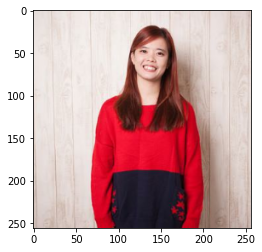

In [ ]:
import matplotlib.pyplot as plt

image = next(iter(X_train_clear_10))[0]
plt.imshow(image*0.5+0.5)
plt.show()

# CIFAR-100
Az eljárások adathalmazok közötti vizsgálatához.

In [ ]:
(X_train_cifar_100, y_train_cifar_100), (X_test_cifar_100, y_test_cifar_100) = tf.keras.datasets.cifar100.load_data()

In [ ]:
n_classes = 100
X_train_cifar_100 = (X_train_cifar_100 / 127.5) -1
X_test_cifar_100 = (X_test_cifar_100 / 127.5) -1
y_train_cifar_100 = tf.keras.utils.to_categorical(y_train_cifar_100, n_classes)
y_test_cifar_100 = tf.keras.utils.to_categorical(y_test_cifar_100, n_classes)

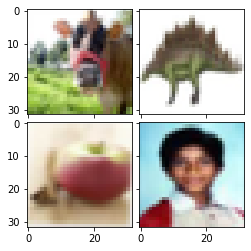

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1, )

for ax, i in zip(grid, range(4)):
    ax.imshow(X_train_cifar_100[i] * 0.5 + 0.5)

# The stolen model

In [6]:
import keras
import keras.layers as layer
import math
import logging
import numpy as np


#import torch
#from torch import nn
#import torch.utils.data
#from torch.nn import functional as F

import tensorflow as tf


GatedDense = None
Reshape = None
#from VAE.layers import GatedDense
#from utils import Reshape

In [5]:


# Generative Models
# -----------------------------------------------------------------------------------

# We will use it as an autoencoder for now
class CVAE(keras.Model):
    def __init__(self, d, args, **kwargs):
        super(CVAE, self).__init__()

        self.encoder = keras.Sequential(
            layer.Conv2d(3, d, kernel_size=4, stride=2, padding=1, bias=False),
            layer.BatchNorm2d(d),
            layer.ReLU(inplace=True),

            layer.Conv2d(d, d, kernel_size=4, stride=2, padding=1, bias=False),
            layer.BatchNorm2d(d),
            layer.ReLU(inplace=True),

            layer.Conv2d(d, d, kernel_size=4, stride=2, padding=1, bias=False),
            layer.BatchNorm2d(d),
            layer.ReLU(inplace=True),

            #nn.Conv2d(d, d, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(d),
            #nn.ReLU(inplace=True),

            ResBlock(d, d, bn=True),
            layer.BatchNorm2d(d),
            ResBlock(d, d, bn=True),
        )

        self.decoder = keras.Sequential(
            ResBlock(d, d, bn=True),
            layer.BatchNorm2d(d),
            ResBlock(d, d, bn=True),
            layer.BatchNorm2d(d),

            layer.ConvTranspose2d(d, d, kernel_size=4, stride=2, padding=1, bias=False),
            layer.BatchNorm2d(d),
            layer.ReLU(inplace=True),

            #nn.ConvTranspose2d(d, d, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(d),
            #nn.ReLU(inplace=True),

            layer.ConvTranspose2d(d, d, kernel_size=4, stride=2, padding=1, bias=False),
            layer.BatchNorm2d(d),
            layer.ReLU(inplace=True),
            layer.ConvTranspose2d(d, 3, kernel_size=4, stride=2, padding=1, bias=False),
        )

        #size of the latent space
        self.f = 4 #8

        #number of chanels in convolutional layer
        self.d = d

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(-1, self.d * self.f ** 2)
        return h1
    
    def decode(self, z):
        z = z.view(-1, self.d, self.f, self.f)
        h3 = self.decoder(z)
        return np.tanh(h3)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = tf.Variable(std.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def call(self, x):
        #mu, logvar = self.encode(x)
        #z = self.reparameterize(mu, logvar)
        #return self.decode(z), mu, logvar
        hid = self.encode(x)
        return self.decode(hid), hid

    def sample(self, size):
        sample = tf.Variable(np.randn(size, self.d * self.f ** 2), requires_grad=False)
        if self.cuda():
            sample = sample.cuda()
        return self.decode(sample).cpu()


    def loss_function(self, x, recon_x, mu, logvar):
        self.mse = keras.losses.MeanSquaredError()(recon_x, x)
        batch_size = x.size(0)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        self.kl_loss = -0.5 * np.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        self.kl_loss /= batch_size * 3 * 1024

        # return mse
        return self.mse + self.kl_coef * self.kl_loss

class ResBlock(keras.Model):
    def __init__(self, in_channels, channels, bn=False):
        super(ResBlock, self).__init__()

        layers = [
           layer.ReLU(),
           layer.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1),
           layer.ReLU(),
           layer.Conv2d(in_channels, channels, kernel_size=1, stride=1, padding=0)]
        if bn:
            layers.insert(2,layer.BatchNorm2d(channels))
        self.convs =layer.Sequential(*layers)

    def call(self, x):
        return x + self.convs(x)





# Classifiers
# -----------------------------------------------------------------------------------

def conv3x3(in_planes, out_planes, stride=1):
    return layer.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(keras.Model):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 =layer.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 =layer.BatchNorm2d(planes)

        self.shortcut =layer.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut =layer.Sequential(
               layer.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
               layer.BatchNorm2d(self.expansion * planes)
            )

    def call(self, x):
        out = layer.ReLU(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = layer.ReLU(out)
        return out

class CategoricalConditionalBatchNorm(keras.Model):
    # as in the chainer SN-GAN implementation, we keep per-cat weight and bias
    def __init__(self, num_features, num_cats, eps=2e-5, momentum=0.1, affine=True, track_running_stats=True):
        super(CategoricalConditionalBatchNorm, self).__init__()
        self.num_features = num_features
        self.num_cats = num_cats
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.weight = self.add_weight(name='weight', shape=(num_cats, num_features), initializer='glorot_uniform')
            self.bias = self.add_weight(name='bias', shape=(num_cats, num_features), initializer='zeros')
        else:
            self.weight = None
            self.bias = None
        if self.track_running_stats:
            self.running_mean = self.add_weight(name='running_mean', shape=(num_features,), initializer='zeros', trainable=False)
            self.running_var = self.add_weight(name='running_var', shape=(num_features,), initializer='ones', trainable=False)
            self.num_batches_tracked = self.add_weight(name='num_batches_tracked', shape=(), initializer='zeros', trainable=False)
        else:
            self.running_mean = None
            self.running_var = None
            self.num_batches_tracked = None
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.assign(tf.zeros_like(self.running_mean))
            self.running_var.assign(tf.ones_like(self.running_var))
            self.num_batches_tracked.assign(tf.zeros_like(self.num_batches_tracked))

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.assign(tf.ones_like(self.weight))
            self.bias.assign(tf.zeros_like(self.bias))

    def call(self, input, cats):
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked.assign_add(1)
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / tf.cast(self.num_batches_tracked, tf.float32)
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        if self.track_running_stats:
            out, batch_mean, batch_var = tf.nn.fused_batch_norm(
                input, scale=None, offset=None, mean=None, variance=None,
                epsilon=self.eps, is_training=self.training or not self.track_running_stats,
                data_format='NHWC')
        else:
            out, batch_mean, batch_var = tf.nn.fused_batch_norm(
                input, scale=None, offset=None, mean=None, variance=None,
                epsilon=self.eps, is_training=self.training,
                data_format='NHWC')

        if self.training and self.track_running_stats:
            self.running_mean.assign((1.0 - exponential_average_factor) * self.running_mean + exponential_average_factor * batch_mean)
            self.running_var.assign((1.0 - exponential_average_factor) * self.running_var + exponential_average_factor * batch_var)

        if self.affine:
            weight = tf.gather(self.weight, cats)
            bias = tf.gather(self.bias, cats)
            weight = tf.expand_dims(tf.expand_dims(weight, 0), 0)
            bias = tf.expand_dims(tf.expand_dims(bias, 0), 0)
            out = out * weight + bias

        return out

class ResNet(tf.keras.Model):
    def __init__(self, block, num_blocks, num_classes, nf, input_size):
        super(ResNet, self).__init__()
        self.in_planes = nf
        self.input_size = input_size

        self.conv1 = tf.keras.layers.Conv2D(nf * 1, kernel_size=3, strides=1, padding='same', input_shape=input_size)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)

        # hardcoded for now
        last_hid = nf * 8 * block.expansion if input_size[1] in [8,16,21,32,42] else 640
        self.linear = tf.keras.layers.Dense(num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return tf.keras.Sequential(layers)

    def return_hidden(self, x):
        out = tf.nn.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = tf.nn.avg_pool2d(out, ksize=4, strides=4, padding='VALID')
        out = tf.reshape(out, (out.shape[0], -1))
        return out

    def call(self, x):
        out = self.return_hidden(x)
        out = self.linear(out)
        return out



def ResNet18(nclasses, nf=20, input_size=(3, 32, 32)):
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf, input_size)

class MLP(tf.keras.Model):
    def __init__(self, args, num_classes=10, nf=400):
        super(MLP, self).__init__()

        self.input_size = int(np.prod(args.input_size))
        self.hidden = tf.keras.Sequential([
                                    tf.keras.layers.Dense(nf),
                                    tf.keras.layers.ReLU(),
                                    tf.keras.layers.Dense(nf),
                                    tf.keras.layers.ReLU()])

        self.linear = tf.keras.layers.Dense(num_classes)

    def return_hidden(self,x):
        x = tf.reshape(x, [-1, self.input_size])
        return self.hidden(x)

    def call(self, x):
        out = self.return_hidden(x)
        return self.linear(out)

        

''' classifier for GEN and GEN-MIR'''
class classifier(keras.Model):
    def __init__(self, args):
        super(classifier, self).__init__()

        K = args.cls_hiddens
        L = np.prod(args.input_size)
        n_classes = args.n_classes
        self.args = args

        activation =layer.ReLU()
        self.layer =layer.Sequential(
            Reshape([-1]),
            GatedDense(L, K, activation=activation),
           layer.Dropout(p=0.2),
            GatedDense(K, n_classes, activation=None)
        )

        # get gradient dimension:
        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())

    def call(self, x):
        out = self.layer(x)
        return out


In [ ]:
import numpy as np
import math
from copy import deepcopy
import pdb

#import torch
#import torch.nn as nn
#import torch.nn.functional as F

from utils import get_grad_vector, get_future_step_parameters
from VAE.loss import calculate_loss

In [ ]:
#át kell még varázsolni

def retrieve_gen_for_gen(args, x, gen, prev_gen, prev_cls):

    grad_vector = get_grad_vector(args, gen.parameters, gen.grad_dims)

    virtual_gen = get_future_step_parameters(gen, grad_vector, gen.grad_dims, args.lr)

    _, z_mu, z_var, _, _, _ = prev_gen(x)

    z_new_max = None
    for i in range(args.n_mem):

        with torch.no_grad():

            if args.mir_init_prior:
                z_new = prev_gen.prior.sample((z_mu.shape[0],)).to(args.device)
            else:
                z_new = prev_gen.reparameterize(z_mu, z_var)

        for j in range(args.mir_iters):
            z_new.requires_grad = True

            x_new = prev_gen.decode(z_new)


            prev_x_mean, prev_z_mu, prev_z_var, prev_ldj, prev_z0, prev_zk = \
                    prev_gen(x_new)
            _, prev_rec, prev_kl, _ = calculate_loss(prev_x_mean, x_new, prev_z_mu, \
                    prev_z_var, prev_z0, prev_zk, prev_ldj, args, beta=1)

            virtual_x_mean, virtual_z_mu, virtual_z_var, virtual_ldj, virtual_z0, virtual_zk = \
                    virtual_gen(x_new)
            _, virtual_rec, virtual_kl, _ = calculate_loss(virtual_x_mean, x_new, virtual_z_mu, \
                    virtual_z_var, virtual_z0, virtual_zk, virtual_ldj, args, beta=1)

            #TODO(warning, KL can explode)


            # maximise the interference
            KL = 0
            if args.gen_kl_coeff>0.:
                KL = virtual_kl - prev_kl

            REC = 0
            if args.gen_rec_coeff>0.:
                REC = virtual_rec - prev_rec

            # the predictions from the two models should be confident
            ENT = 0
            if args.gen_ent_coeff>0.:
                y_pre = prev_cls(x_new)
                ENT = cross_entropy(y_pre, y_pre)
            #TODO(should we do the args.curr_entropy thing?)

            DIV = 0
            # the new found samples samples should be differnt from each others
            if args.gen_div_coeff>0.:
                for found_z_i in range(i):
                    DIV += F.mse_loss(
                        z_new,
                        z_new_max[found_z_i * z_new.size(0):found_z_i * z_new.size(0) + z_new.size(0)]
                        ) / (i)

            # (NEW) stay on gaussian shell loss:
            SHELL = 0
            if args.gen_shell_coeff>0.:
                SHELL = mse(torch.norm(z_new, 2, dim=1),
                        torch.ones_like(torch.norm(z_new, 2, dim=1))*np.sqrt(args.z_size))

            gain = args.gen_kl_coeff * KL + \
                   args.gen_rec_coeff * REC + \
                   -args.gen_ent_coeff * ENT + \
                   args.gen_div_coeff * DIV + \
                   -args.gen_shell_coeff * SHELL

            z_g = torch.autograd.grad(gain, z_new)[0]
            z_new = (z_new + 1 * z_g).detach()


        if z_new_max is None:
            z_new_max = z_new.clone()
        else:
            z_new_max = torch.cat([z_new_max, z_new.clone()])

    z_new_max.require_grad = False

    if np.isnan(z_new_max.to('cpu').numpy()).any():
        mir_worked = 0
        mem_x = prev_gen.generate(args.batch_size*args.n_mem).detach()
    else:
        mem_x = prev_gen.decode(z_new_max).detach()
        mir_worked = 1

    return mem_x, mir_worked

In [ ]:
import argparse
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import pdb
import wandb

import mir
from data   import *
from utils  import get_logger, get_temp_logger, logging_per_task, onehot, distillation_KL_loss, \
                   naive_cross_entropy_loss, get_grad_vector, get_future_step_parameters
from copy   import deepcopy
from pydoc  import locate
from model  import ResNet18, CVAE, MLP, classifier
from VAE    import VAE
from VAE.loss import calculate_loss

# Arguments
# -----------------------------------------------------------------------------------------

parser = argparse.ArgumentParser()
parser.add_argument('-u', '--unit_test', action='store_true',
    help='unit testing mode for fast debugging')
parser.add_argument('-d', '--dataset', type=str, default = 'split_mnist',
    choices=['split_mnist', 'permuted_mnist', 'split_cifar10', 'split_cifar100', 'miniimagenet'])
parser.add_argument('--n_tasks', type=int, default=-1,
    help='total number of tasks. -1 does default amount for the dataset')
parser.add_argument('-r','--reproc', type=int, default=1,
    help='if on, no randomness in numpy and torch')
parser.add_argument('--n_epochs', type=int, default=1)
parser.add_argument('--cls_iters', type=int, default=1,
    help='number of training iterations for the classifier')
parser.add_argument('--gen_iters', type=int, default=1,
    help='number of training iterations for the generator')
parser.add_argument('--cls_hiddens', type=int, default=400,
    help='number hidden dim in the classifier')
parser.add_argument('-bs', '--batch_size', type=int, default=10)
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--use_conv', action='store_true')
parser.add_argument('-s', '--samples_per_task', type=int, default=-1,
    help='if negative, full dataset is used')
parser.add_argument('--n_runs', type=int, default=1,
    help='number of runs to average performance')
parser.add_argument('-pe', '--print_every', type=int, default=100,
    help="print metrics every this minibatch")
# logging
parser.add_argument('-l', '--log', type=str, default='off', choices=['off', 'online', 'offline'],
    help='enable WandB logging')
parser.add_argument('--result_dir', type=str, default='temp',
    help='directory inside Results/ where we save results, samples and WandB project')
parser.add_argument('--name', type=str, default=None,
    help='name of the run in WandB project')

#------ MIR -----#
parser.add_argument('-m','--method', type=str, default='rand_gen',
    choices=['no_rehearsal','rand_gen', 'mir_gen'])
parser.add_argument('-gm', '--gen_method', type=str, default='rand_gen',
    choices=['no_rehearsal', 'mir_gen', 'rand_gen'])
parser.add_argument('--reuse_samples', type=int, default=0)
parser.add_argument('--n_mem', type=int, default=1,
    help='number of retrieved memories')
parser.add_argument('-mc', '--mem_coeff', type=float, default=1.0, # not like Lucas' and Eug's
    help='replay loss relative weight')
parser.add_argument('--mir_iters', type=int, default=1,
    help='number of gradient descent iterations for MIR')
parser.add_argument('-mip', '--mir_init_prior', type=int, default=1,
    help='if on, we start the mir search at the prior, not the posterior')
# coeff
parser.add_argument('-cxc', '--cls_xent_coeff', type=float, default=1.0,
    help='coeff for the classification loss')
parser.add_argument('-cec', '--cls_ent_coeff', type=float, default=1.0,
    help='regularization to encourage samples with high certainty')
parser.add_argument('-cdc', '--cls_div_coeff', type=float, default=1.0,
    help='regularization to encourage diversity in retrieved samples for classifier')
parser.add_argument('-csc', '--cls_shell_coeff', type=float, default=1.,
    help='regularization such that z stays near the gaussian shell')
parser.add_argument('-grc', '--gen_rec_coeff', type=float, default=1.0,
    help='coeff for Reconstruction cost')
parser.add_argument('-gkc', '--gen_kl_coeff', type=float, default=1.0,
    help='coeff for KL cost')
parser.add_argument('-gec', '--gen_ent_coeff', type=float, default=1.0,
    help='regularization to encourage samples with high certainty')
parser.add_argument('-gdc', '--gen_div_coeff', type=float, default=1.,
    help='regularization to encourage diversity in retrieved samples for classifier')
parser.add_argument('-gsc', '--gen_shell_coeff', type=float, default=1.,
    help='regularization such that z stays near the gaussian shell')
#----------------#

#------- Generative Model ------#
parser.add_argument('-o', '--output_loss', type=str, default=None,
    choices=[None, 'bernouilli', 'mse', 'multinomial'])
parser.add_argument('-ga', '--gen_architecture', type=str, default='MLP',
    choices=['MLP', 'GatedConv'])
parser.add_argument('-gd', '--gen_depth', type=int, default=1,
    help='depth of the generator (fixed to 6 in GatedConv)')
parser.add_argument('-gh', '--gen_hiddens', type=int, default=256,
    help='number of hidden variable in generator')
parser.add_argument('-do', '--dropout', type=float, default=0,
    help='dropout probability')
parser.add_argument('-w', '--warmup', type=int, default=1000, metavar='N',
    help='number of datapoints for warm-up. Set to 0 to turn warmup off.')
parser.add_argument('--max_beta', type=float, default=1.,
    help='max beta for warm-up')
parser.add_argument('--min_beta', type=float, default=0.0,
    help='min beta for warm-up')
parser.add_argument('--z_size', type=int, default=64,
    help='how many stochastic hidden units')
parser.add_argument('-f', '--flow', type=str, default='no_flow',
    choices=['no_flow'])
    # choices=['planar', 'iaf', 'householder', 'orthogonal','triangular', 'no_flow'])
# not implemented yet:
parser.add_argument('-nf', '--num_flows', type=int, default=4,
    help='Number of flow layers, ignored in absence of flows')
parser.add_argument('-nv', '--num_ortho_vecs', type=int, default=8,
    help="For orthogonal flow: How orthogonal vectors per flow do you need.")
parser.add_argument('-nh', '--num_householder', type=int, default=8,
    help="For Householder Sylvester flow: Number of Householder matrices per flow.")
parser.add_argument('-mhs', '--made_h_size', type=int, default=320,
    help='Width of mades for iaf. Ignored for all other flows.')
#---------------------------------#

args = parser.parse_args()

# Obligatory overhead
# -----------------------------------------------------------------------------------------

result_path = os.path.join('Results', args.result_dir)
if not os.path.exists(result_path): os.mkdir(result_path)
sample_path = os.path.join(*['Results', args.result_dir, 'samples/'])
if not os.path.exists(sample_path): os.mkdir(sample_path)
recon_path = os.path.join(*['Results', args.result_dir, 'reconstructions/'])
if not os.path.exists(recon_path): os.mkdir(recon_path)
mir_path = os.path.join(*['Results', args.result_dir, 'mir/'])
if not os.path.exists(mir_path): os.mkdir(mir_path)

args.cuda = torch.cuda.is_available()
if args.cuda: args.device = 'cuda:0'
else: args.device = 'cpu'


# TODO(this in utils)
if args.unit_test:
    args.n_epochs = 1
    args.gen_iters = 2
    args.cls_iters = 2
    args.batch_size = 5
    args.max_loss_budget = 2
    args.max_loss_grad_steps = 2

if args.method == args.gen_method == 'no_rehearsal':
    args.gen_iters = 0
    args.fully_train_on_gen = 0

# pre logging stuff
if args.gen_architecture=='GatedConv':
    args.gen_depth = 6
args.cls_mir_gen = 1 if args.method=='mir_gen' else 0
args.gen_mir_gen = 1 if args.gen_method=='mir_gen' else 0

if args.reproc:
    seed=0
    torch.manual_seed(seed)
    np.random.seed(seed)

# fetch data
data = locate('data.get_%s' % args.dataset)(args)

# make dataloaders
train_loader, val_loader, test_loader  = [CLDataLoader(elem, args, train=t) \
        for elem, t in zip(data, [True, False, False])]

if args.log != 'off':
    #os.environ['WANDB_MODE'] = 'dryrun'
    if args.name is None: wandb.init(project=args.result_dir)
    else: wandb.init(project=args.result_dir, name=args.name)
    wandb.config.update(args)
else:
    wandb = None

# create logging containers
LOG = get_logger(['gen_loss', 'cls_loss', 'acc'],
        n_runs=args.n_runs, n_tasks=args.n_tasks)


# Train the model
# -----------------------------------------------------------------------------------------

# --------------
# Begin Run Loop
for run in range(args.n_runs):

    mir_tries, mir_success = 0, 0

    # REPRODUCTIBILITY
    if args.reproc:
        np.random.seed(run)
        torch.manual_seed(run)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # CLASSIFIER
    if args.use_conv:
        cls = ResNet18(args.n_classes, nf=20, input_size=args.input_size)
    else:
        #cls = MLP(args)
        cls = classifier(args).to(args.device)

    opt = torch.optim.SGD(cls.parameters(), lr=args.lr)
    if run == 0:
        print("number of classifier parameters:",
                sum([np.prod(p.size()) for p in cls.parameters()]))

    # GENERATIVE MODELING
    if (args.method is not 'no_rehearsal') or (args.gen_method is not 'no_rehearsal'):
        gen = VAE.VAE(args).to(args.device)
        #if args.cuda:
        #    gen = gen.cuda()
        opt_gen = torch.optim.Adam(gen.parameters())
        if run == 0:
            print("number of generator parameters: ",
                    sum([np.prod(p.size()) for p in gen.parameters()]))
    else:
        gen=None

    # INIT
    prev_gen, prev_model = None, None

    #----------------
    # Begin Task Loop
    for task, tr_loader in enumerate(train_loader):

        print('\n--------------------------------------')
        print('Run #{} Task #{} TRAIN'.format(run, task))
        print('--------------------------------------\n')

        cls = cls.train()
        if gen is not None:
            gen = gen.train()

        sample_amt = 0

        # ----------------
        # Begin Epoch Loop
        for epoch in range(args.n_epochs):

            #---------------------
            # Begin Minibatch Loop
            for i, (data, target) in enumerate(tr_loader):

                if args.unit_test and i > 10: break
                if sample_amt > args.samples_per_task > 0: break
                sample_amt += data.size(0)

                #if args.cuda:
                data, target = data.to(args.device), target.to(args.device)

                args.beta = min([(sample_amt) / max([args.warmup, 1.]), args.max_beta])

                #------ Train Generator ------#

                #-------------------------------
                # Begin Generator Iteration Loop
                for it in range(args.gen_iters):

                    x_mean, z_mu, z_var, ldj, z0, zk = gen(data)
                    gen_loss, rec, kl, _ = calculate_loss(x_mean, data, z_mu,
                            z_var, z0, zk, ldj, args, beta=args.beta)

                    tot_gen_loss = 0 + gen_loss

                    if task > 0 and args.gen_method != 'no_rehearsal':

                        if it == 0 or not args.reuse_samples:

                            if args.gen_method == 'rand_gen':
                                mem_x = prev_gen.generate(args.batch_size*args.n_mem).detach()

                            elif args.gen_method == 'mir_gen':

                                mem_x, mir_worked = \
                                    mir.retrieve_gen_for_gen(args, data, gen, prev_gen, prev_cls)

                                mir_tries += 1
                                if mir_worked:
                                    mir_success += 1
                                    # keep for logging later
                                    gen_x, gen_mem_x = data, mem_x

                        mem_x_mean, z_mu, z_var, ldj, z0, zk = gen(mem_x)
                        mem_gen_loss, mem_rec, mem_kl, _ = calculate_loss(mem_x_mean, mem_x, z_mu,
                                z_var, z0, zk, ldj, args, beta=args.beta)

                        tot_gen_loss += args.mem_coeff * mem_gen_loss

                    opt_gen.zero_grad()
                    tot_gen_loss.backward()
                    opt_gen.step()

                # End Generator Iteration Loop
                #------------------------------

                if gen is not None:
                    if i % args.print_every == 0:
                        print('current VAE loss = {:.4f} (rec: {:.4f} + beta: {:.2f} * kl: {:.2f})'
                            .format(gen_loss.item(), rec.item(), args.beta, kl.item()))
                        if task > 0:
                            print('memory VAE loss = {:.4f} (rec: {:.4f} + beta: {:.2f} * kl: {:.2f})'
                                .format(mem_gen_loss.item(), mem_rec.item(), args.beta, mem_kl.item()))


                #------ Train Classifier-------#

                #--------------------------------
                # Begin Classifier Iteration Loop
                for it in range(args.cls_iters):

                    logits = cls(data)
                    cls_loss = F.cross_entropy(logits, target, reduction='mean')
                    tot_cls_loss = 0 + cls_loss

                    if task > 0 and args.method != 'no_rehearsal':

                        if it == 0 or not args.reuse_samples:

                            if args.method=='rand_gen':
                                mem_x = prev_gen.generate(args.batch_size*args.n_mem).detach()
                                mem_y = torch.softmax(prev_cls(mem_x), dim=1).detach()

                            elif args.method=='mir_gen':

                                mem_x, mem_y, mir_worked = \
                                    mir.retrieve_gen_for_cls(args, data, cls, prev_cls, prev_gen)

                                mir_tries += 1
                                if mir_worked:
                                    mir_success += 1
                                    # keep for logging later
                                    cls_x, cls_mem_x = data, mem_x

                        mem_logits = cls(mem_x)

                        mem_cls_loss = naive_cross_entropy_loss(mem_logits, mem_y)

                        tot_cls_loss += args.mem_coeff * mem_cls_loss

                    opt.zero_grad()
                    tot_cls_loss.backward()
                    opt.step()

                # End Classifer Iteration Loop
                #-----------------------------

                if i % args.print_every == 0:
                    pred = logits.argmax(dim=1, keepdim=True)
                    acc = pred.eq(target.view_as(pred)).sum().item() / pred.size(0)
                    print('current training accuracy: {:.2f}'.format(acc))
                    if task > 0 and args.method != 'no_rehearsal':
                        pred = mem_logits.argmax(dim=1, keepdim=True)
                        mem_y = mem_y.argmax(dim=1, keepdim=True)
                        acc = pred.eq(mem_y.view_as(pred)).sum().item() / pred.size(0)
                        print('memory training accuracy: {:.2f}'.format(acc))

            # End Minibatch Loop
            #-------------------

        # End Epoch Loop
        #---------------

        # ------------------------ eval ------------------------ #

        print('\n--------------------------------------')
        print('Run #{} Task #{} EVAL'.format(run, task))
        print('--------------------------------------\n')

        with torch.no_grad():

            cls = cls.eval()
            prev_cls = deepcopy(cls)

            if gen is not None:
                gen = gen.eval()
                prev_gen = deepcopy(gen)

                if args.dataset is not 'permuted_mnist':

                    # save some training reconstructions:
                    recon_path_ = os.path.join(recon_path,'task{}.png'.format(task))
                    recons = torch.cat([data.to('cpu'), x_mean.to('cpu')])
                    save_image(recons, recon_path_, nrow=args.batch_size)
                    if wandb is not None:
                        logged_og = wandb.Image(data.to('cpu'),
                            caption="OG task {}".format(task))
                        wandb.log({"OG Run {}".format(run): logged_og}, step=task)
                        logged_recons = wandb.Image(x_mean.to('cpu'),
                            caption="reconstructions task {}".format(task))
                        wandb.log({"Reconstructions Run {}".format(run): logged_recons}, step=task)

                    # save some pretty images:
                    gen_images = gen.generate(25).to('cpu')
                    sample_path_ = os.path.join(sample_path,'task{}.png'.format(task))
                    save_image(gen_images, sample_path_, nrow=5)
                    if wandb is not None:
                        logged_gen = wandb.Image(gen_images[:16],
                            caption="generations task {}".format(task))
                        wandb.log({"Generations Run {}".format(run): logged_gen}, step=task)

                    # save some MIR samples:
                    if task>0:
                        if 'mir_gen'==args.method:
                            mir_images = torch.cat([cls_x.to('cpu'),
                                    cls_mem_x.to('cpu')])
                            mir_path_ = os.path.join(mir_path,'cls_task{}.png'.format(task))
                            save_image(mir_images, mir_path_, nrow=10)
                        if 'mir_gen'==args.gen_method:
                            mir_images = torch.cat([gen_x.to('cpu'),
                                    gen_mem_x.to('cpu')])
                            mir_path_ = os.path.join(mir_path,'gen_task{}.png'.format(task))
                            save_image(mir_images, mir_path_, nrow=10)


            eval_loaders = [('valid', val_loader), ('test', test_loader)]

            #----------------
            # Begin Eval Loop
            for mode, loader_ in eval_loaders:

                #----------------
                # Begin Task Eval Loop
                for task_t, te_loader in enumerate(loader_):
                    if task_t > task: break
                    LOG_temp = get_temp_logger(None, ['gen_loss', 'cls_loss', 'acc'])

                    #---------------------
                    # Begin Minibatch Eval Loop
                    for i, (data, target) in enumerate(te_loader):
                        if args.unit_test and i > 10: break

                        #if args.cuda:
                        data, target = data.to(args.device), target.to(args.device)

                        logits = cls(data)

                        loss = F.cross_entropy(logits, target)
                        pred = logits.argmax(dim=1, keepdim=True)

                        LOG_temp['acc'] += [pred.eq(target.view_as(pred)).sum().item() / pred.size(0)]
                        LOG_temp['cls_loss'] += [loss.item()]

                        if gen is not None:
                            x_mean, z_mu, z_var, ldj, z0, zk = gen(data)
                            gen_loss, rec, kl, bpd = calculate_loss(x_mean, data, z_mu, z_var, z0,
                                    zk, ldj, args, beta=args.beta)
                            LOG_temp['gen_loss'] += [gen_loss.item()]

                    # End Minibatch Eval Loop
                    #-------------------

                    logging_per_task(wandb, LOG, run, mode, 'acc', task, task_t,
                             np.round(np.mean(LOG_temp['acc']),2))
                    logging_per_task(wandb, LOG, run, mode, 'cls_loss', task, task_t,
                             np.round(np.mean(LOG_temp['cls_loss']),2))
                    logging_per_task(wandb, LOG, run, mode, 'gen_loss', task, task_t,
                             np.round(np.mean(LOG_temp['gen_loss']),2))


                # End Task Eval Loop
                #-------------------

                print('\n{}:'.format(mode))
                print(LOG[run][mode]['acc'])

            # End Eval Loop
            #--------------

        # End torch.no_grad()
        #--------------------

    # End Task Loop
    #--------------

    print('--------------------------------------')
    print('Run #{} Final Results'.format(run))
    print('--------------------------------------')
    for mode in ['valid','test']:

        # accuracy
        final_accs = LOG[run][mode]['acc'][:,task]
        logging_per_task(wandb, LOG, run, mode, 'final_acc', task,
            value=np.round(np.mean(final_accs),2))

        # forgetting
        best_acc = np.max(LOG[run][mode]['acc'], 1)
        final_forgets = best_acc - LOG[run][mode]['acc'][:,task]
        logging_per_task(wandb, LOG, run, mode, 'final_forget', task,
                value=np.round(np.mean(final_forgets[:-1]),2))

        # VAE loss
        final_elbos = LOG[run][mode]['gen_loss'][:,task]
        logging_per_task(wandb, LOG, run, mode, 'final_elbo', task,
            value=np.round(np.mean(final_elbos),2))

        print('\n{}:'.format(mode))
        print('final accuracy: {}'.format(final_accs))
        print('average: {}'.format(LOG[run][mode]['final_acc']))
        print('final forgetting: {}'.format(final_forgets))
        print('average: {}'.format(LOG[run][mode]['final_forget']))
        print('final VAE loss: {}'.format(final_elbos))
        print('average: {}\n'.format(LOG[run][mode]['final_elbo']))

        try:
            mir_worked_frac = mir_success/(mir_tries)
            logging_per_task(wandb, LOG, run, mode, 'final_mir_worked_frac', task,
                mir_worked_frac)
            print('mir worked \n', mir_worked_frac)
        except:
            pass

# End Run Loop
#-------------

print('--------------------------------------')
print('--------------------------------------')
print('FINAL Results')
print('--------------------------------------')
print('--------------------------------------')
for mode in ['valid','test']:

    # accuracy
    final_accs = [LOG[x][mode]['final_acc'] for x in range(args.n_runs)]
    final_acc_avg = np.mean(final_accs)
    final_acc_se = np.std(final_accs) / np.sqrt(args.n_runs)

    # forgetting
    final_forgets = [LOG[x][mode]['final_forget'] for x in range(args.n_runs)]
    final_forget_avg = np.mean(final_forgets)
    final_forget_se = np.std(final_forgets) / np.sqrt(args.n_runs)

    # VAE loss
    final_elbos = [LOG[x][mode]['final_elbo'] for x in range(args.n_runs)]
    final_elbo_avg = np.mean(final_elbos)
    final_elbo_se = np.std(final_elbos) / np.sqrt(args.n_runs)

    # MIR worked
    try:
        final_mir_worked_frac = [LOG[x][mode]['final_mir_worked_frac'] for x in range(args.n_runs)]
        final_mir_worked_avg = np.mean(final_mir_worked_frac)
    except:
        pass

    print('\nFinal {} Accuracy: {:.3f} +/- {:.3f}'.format(mode, final_acc_avg, final_acc_se))
    print('\nFinal {} Forget: {:.3f} +/- {:.3f}'.format(mode, final_forget_avg, final_forget_se))
    print('\nFinal {} ELBO: {:.3f} +/- {:.3f}'.format(mode, final_elbo_avg, final_elbo_se))

    if wandb is not None:
        wandb.log({mode+'final_acc_avg':final_acc_avg})
        wandb.log({mode+'final_acc_se':final_acc_se})
        wandb.log({mode+'final_forget_avg':final_forget_avg})
        wandb.log({mode+'final_forget_se':final_forget_se})
        wandb.log({mode+'final_elbo_avg':final_elbo_avg})
        wandb.log({mode+'final_elbo_se':final_elbo_se})


In [ ]:
""" Template Dataset with Labels """
class XYDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, **kwargs):
        self.x, self.y = x, y

        # this was to store the inverse permutation in permuted_mnist
        # so that we could 'unscramble' samples and plot them
        for name, value in kwargs.items():
            setattr(self, name, value)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]

        if type(x) != torch.Tensor:
            # mini_imagenet
            # we assume it's a path --> load from file
            x = self.transform(Image.open(x).convert('RGB'))
            y = torch.Tensor(1).fill_(y).long().squeeze()
        else:
            x = x.float() / 255.
            y = y.long()


        # for some reason mnist does better \in [0,1] than [-1, 1]
        if self.source == 'mnist':
            return x, y
        else:
            return (x - 0.5) * 2, y


""" Template Dataset for Continual Learning """
class CLDataLoader(object):
    def __init__(self, datasets_per_task, args, train=True):
        bs = args.batch_size if train else 64

        self.datasets = datasets_per_task
        self.loaders = [
                torch.utils.data.DataLoader(x, batch_size=bs, shuffle=True, drop_last=train, num_workers=0)
                for x in self.datasets ]

    def __getitem__(self, idx):
        return self.loaders[idx]

    def __len__(self):
        return len(self.loaders)